# CESM2-LE analysis
## Looks at variabiliy in Crop productivity
### Could also look at changes in crop planting dates, esp. for future scenarios
 - reading in ensemble of data from CESM2_LENS, a relatively large dataset 
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2020.12.0
dask.__version__

'2021.01.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 18
nmem   = str(int(375*ncores/ncores))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='3:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [7]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

Client Scheduler: tcp://10.12.205.30:38710 Dashboard: http://10.12.205.30/proxy/8787/status,Cluster Workers: 18 Cores: 18 Memory: 374.94 GB


### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [8]:
def get_file(ee,model,field,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
        mm = mlist[ee]
        lnd    = '/lnd/proc/tseries/month_1/'
        firstyear = 10*int(yr/10)
        yy    = '.'+str(firstyear)+'01-'+str(firstyear+9)+'12.'
        if yr>2009:
            yy = '.201001-201412.'
        ff     = glob.glob(mm+lnd+'*.h0.'+field+yy+'*')[0]
    return ff

In [9]:
def all_files(model,field,firstyear, nens):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        #nens = 42
        files = [get_file(ee,'CESM1',field,0) for ee in range(nens)]
    else:
        #nens = 50
        yrs = [*np.arange(firstyear,2009,10),2010]
        files = [[get_file(ee,'CESM2',field,yr) for yr in yrs] 
                 for ee in range(nens)]
    return files

In [10]:
def get_monthly(model,fields,firstyear, nens, chunks={'time':500}):
    first = True
    
    for field in fields:
        #find the appropriate files
        files = all_files(model,field,firstyear, nens)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                ds = xr.open_mfdataset(files[0],combine='by_coords',parallel=True,chunks=chunks)
                tmp = xr.open_dataset(files[0][0],chunks=chunks)
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0],chunks=chunks)

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model],chunks=chunks)
        ds[field] = tmp[field]

    ds['landarea'] = ds['area']*ds['landfrac']
    ds['landarea'].name = 'landarea'
    ds['landarea'].attrs['units'] = 'km2'
        
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    ix = ds['time.year']>=firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [11]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [12]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### Actually read the data in

In [13]:
%%time

data_vars = ['TOTVEGC','GRAINC_TO_FOOD','QIRRIG']
model = 'CESM2'
firstyear = 1850
nens = 20  # read in 20 ensemble members for now
ds = get_monthly(model,data_vars,firstyear, nens)

CPU times: user 35 s, sys: 7.59 s, total: 42.6 s
Wall time: 48.8 s


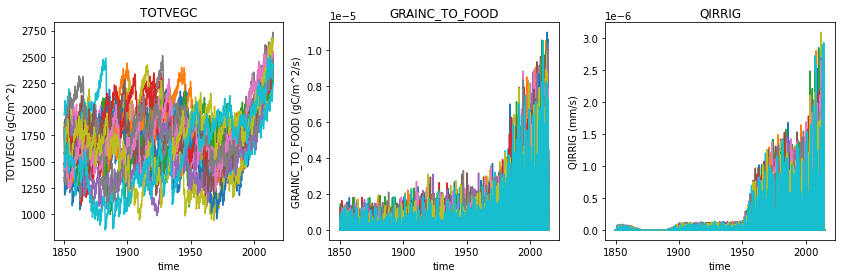

In [14]:
# quick look at single grid 
plt.figure(figsize=[14,4])
for i in range(len(data_vars)):
    temp = ds[data_vars[i]].sel(lat=25, lon=100, method='nearest').transpose('time','ens')
    plt.subplot(1,3,(i+1))
    plt.plot(temp.time, temp)
    plt.title(data_vars[i])
    plt.xlabel('time')
    plt.ylabel(data_vars[i]+' ('+ds[data_vars[i]].attrs['units']+')') ;  

## Sample analyses
- annual fluxes, both from grids and globally

In [54]:
landarea = 1e6*(ds['area']*ds['landfrac']) #m2
landarea = landarea.where(ds[data_vars[0]].max(dim=['ens','time'])>0.) # mask out zero productivity grids
landwgt  = landarea/landarea.sum()

nyears   = len(np.unique(ds['time.year']))
xf1      = 24*60*60    # secs->days
xf2      = 1e-15       # gC->PgC, or Kg->Tt
xf3      = 1e-6*18.015 # umol H20 ->g H20, not used with this code!

days_pm    = [31,28,31,30,31,30,31,31,30,31,30,31]

# Creaete long names and units for each variable to sum / average
varType  =  ['WGTmean','sum','sum']
grid_long = ['Annual TOTVEGC','Annual Food','Annual Irrigation']
glob_long = ['Global sum VEG C','Global mean Food','Global sum QIRRRIG']
grid_unit = [ds.TOTVEGC.attrs['units'], 'gC/m2/y','mm/y']
glob_unit = ['Pg C', 'Pg C/y','Tt H2O']

# Create datasets to hold output 
glob_coords = ds.TOTVEGC.resample(time='Y').mean().sum(dim=['lat','lon']).coords
grid_coords = ds.TOTVEGC.resample(time='Y').mean().coords
ann_grid = xr.Dataset(coords=grid_coords)
ann      = xr.Dataset(coords=glob_coords)
print(ann_grid)

In [55]:
# loop over annual calculations & global sums / means
# loading these data takes extra time, but makes plotting quicker

for i in range(len(data_vars)):    
    if varType[i] == 'sum': # grid weighted by days / month, global sum over land area
        ann_grid[data_vars[i]] = xf1*(month_wts(nyears)*ds[data_vars[i]]).groupby('time.year').sum(skipna=True)
        ann[data_vars[i]] = xf2*(landarea*ann_grid[data_vars[i]]).sum(dim=['lat','lon'])
       
    if varType[i] == 'WGTmean': # grid weighted by days / month, global weighted by area
        ann_grid[data_vars[i]] = (month_wts(nyears)/365*ds[data_vars[i]] ).groupby('time.year').sum(skipna=True)
        ann[data_vars[i]] = (landwgt*ann_grid[data_vars[i]]).sum(dim=['lat','lon'])
        
    if varType[i] == 'mean':  # grid NOT weighted by days / month, global weighted by area
        ann_grid[data_vars[i]] = ds[data_vars[i]].groupby('time.year').mean(skipna=True).transpose('year','ens','lat','lon')
        ann[data_vars[i]] = (landwgt*ann_grid[data_vars[i]]).sum(dim=['lat','lon']).transpose('year','ens')

    ann_grid[data_vars[i]].attrs['long_name'] = grid_long[i]
    ann_grid[data_vars[i]].attrs['units'] = grid_unit[i]
    ann[data_vars[i]].attrs['long_name'] = glob_long[i]
    ann[data_vars[i]].attrs['units'] = glob_unit[i]

print('Annual calculations finished')

starting TOTVEGC
starting GRAINC_TO_FOOD
starting QIRRIG
Annual calculations finished
CPU times: user 3.26 s, sys: 39.1 ms, total: 3.3 s
Wall time: 3.26 s


In [57]:
%%time
# this may not be worth doing...
ann_grid.compute(skipna=True)

CPU times: user 1min 2s, sys: 1min 37s, total: 2min 40s
Wall time: 4min 13s


<xarray.Dataset>
Dimensions:         (ens: 20, lat: 192, lon: 288, time: 165, year: 165)
Coordinates:
  * time            (time) object 1850-12-31 00:00:00 ... 2014-12-31 00:00:00
  * lon             (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat             (lat) float32 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * ens             (ens) int64 0 1 2 3 4 5 6 7 8 ... 11 12 13 14 15 16 17 18 19
  * year            (year) int64 1850 1851 1852 1853 ... 2011 2012 2013 2014
Data variables:
    TOTVEGC         (year, ens, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    GRAINC_TO_FOOD  (year, ens, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    QIRRIG          (year, ens, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

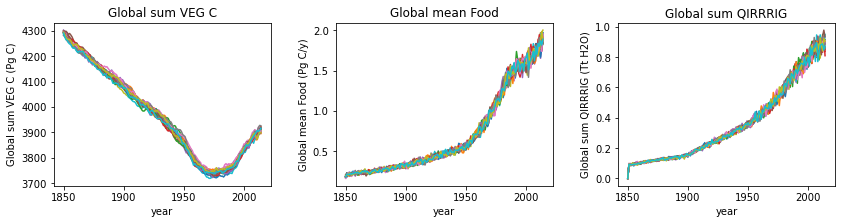

In [56]:
t = np.unique(ann[data_vars[0]].year)

plt.figure(figsize=[14,3])
for i in range(len(data_vars)):
    plt.subplot(1,3,(i+1))
    plt.plot(t, ann[data_vars[i]])
    plt.title(ann[data_vars[i]].attrs['long_name'])
    plt.xlabel('year')
    plt.ylabel(ann[data_vars[i]].attrs['long_name']+' ('+
               ann[data_vars[i]].attrs['units']+')' )

plt.subplots_adjust(wspace=0.3) ;

## Plot regional trends in food production

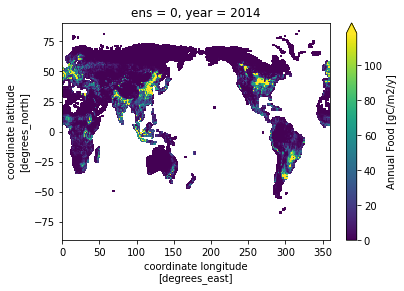

In [30]:
ann_grid[data_vars[1]].where(ds[data_vars[0]].max(dim=['ens','time'])>0).isel(ens=0,year=-1).plot(robust=True) ;

CPU times: user 2min 7s, sys: 4.65 s, total: 2min 12s
Wall time: 3min 1s


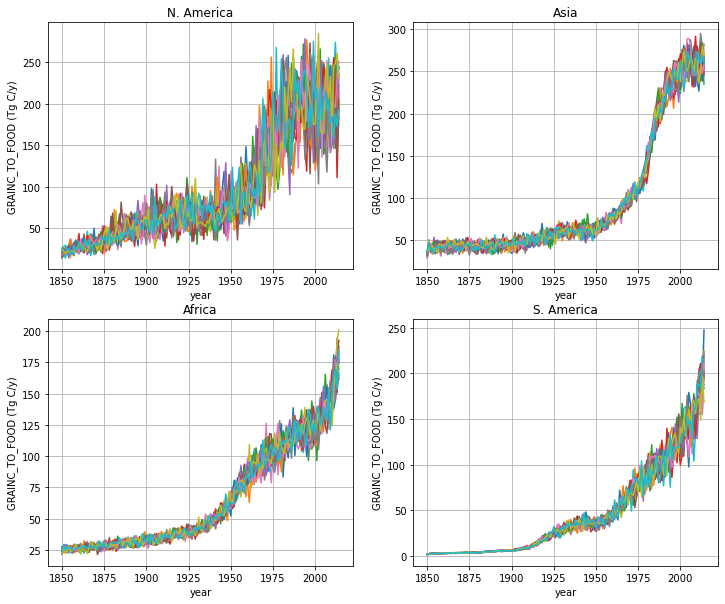

In [58]:
%%time
# sum(annual flux (gC/m2/y) * area) * 1e-12 = TgC/y
# Regions may need to be adjusted
region = ['N. America', 'Asia', 'Africa', 'S. America']
minLat = [25          , 20    , -15     , -40]
maxLat = [55          , 50    ,  15     , -10]
minLon = [260         , 110   ,  0      , 280]
maxLon = [300         , 150   ,  50     , 320]

annFOOD_flux = (landarea*ann_grid[data_vars[1]]).where(ds[data_vars[0]].max(dim=['ens','time'])>0)#.load() 

plt.figure(figsize=[12,10])
for i in range(len(region)):
    plt.subplot(2,2,(1+i))
    regionalFOOD = annFOOD_flux.sel(lat=slice(minLat[i],maxLat[i]),
                                    lon=slice(minLon[i],maxLon[i]) ).sum(['lat','lon']) * 1e-12
    plt.plot(t, regionalFOOD)
    plt.grid()
    plt.ylabel('GRAINC_TO_FOOD (Tg C/y)')
    plt.xlabel('year')
    plt.title(region[i]) ; 

<Figure size 864x720 with 0 Axes>

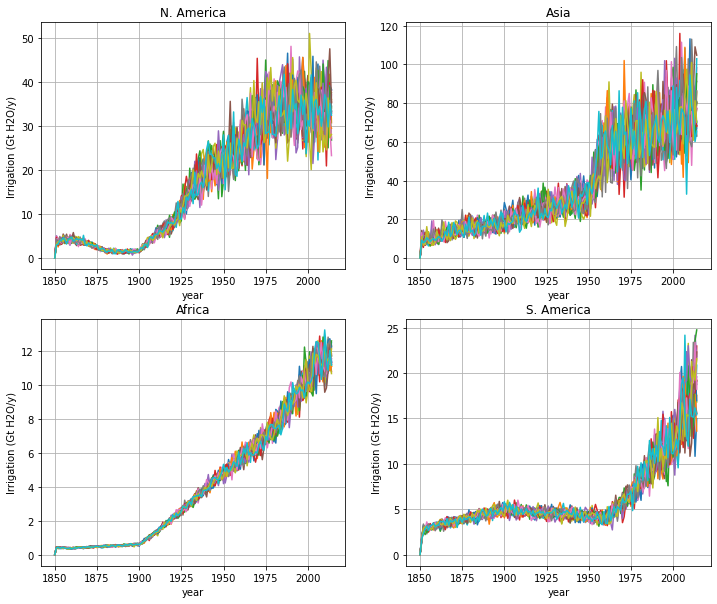

In [59]:
# sum(annual flux (mm H2O/y)* area) * 1e-12 = Gt H2O/y
plt.figure(figsize=[12,10])
annIRRIG_flux = (landarea*ann_grid[data_vars[2]]).where(ds[data_vars[0]].max(dim=['ens','time'])>0) 

plt.figure(figsize=[12,10])
for i in range(len(region)):
    plt.subplot(2,2,(1+i))
    regionalIRRIG = annIRRIG_flux.sel(lat=slice(minLat[i],maxLat[i]),
                                      lon=slice(minLon[i],maxLon[i]) ).sum(['lat','lon']) * 1e-12
    plt.plot(t, regionalIRRIG)
    plt.grid()
    plt.ylabel('Irrigation (Gt H2O/y)')
    plt.xlabel('year')
    plt.title(region[i]) ; 

In [ ]:
#client.close()

In [ ]:
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`